# Cálculo de Redes pelo Método Monte Carlo

In [219]:
import numpy as np
import matplotlib.pyplot as plt
import time as time
import plotly.graph_objects as go

# Função para criar uma rede hidraulica com forma de grade quadrada
def GeraRede(nx,ny,CH,CV):
    nv = nx*ny
    nc = (nx-1)*ny + (ny-1)*nx
    
    coord = np.zeros(shape=(nv,2))

    for i in range(nx):
      for j in range(ny):
        ig = i + j*nx
        coord[ig,0] = i
        coord[ig,1] = j

    conec = np.zeros(shape=(nc,2), dtype=int)
    C = np.zeros(nc)
    
    # Loop sobre canos horizontais
    for j in range(ny):
        for i in range(nx-1):
          k = j*(nx-1) + i
          conec[k,0] = j*nx + i
          conec[k,1] = j*nx + i+1
          C[k] = CH

    # Loop sobre canos verticais
    for i in range(nx):
      for j in range(ny-1):
          k = (nx-1)*ny + j*nx + i
          conec[k,0] = i + j*nx
          conec[k,1] = i + (j+1)*nx
          C[k] = CV

    return nv, nc, conec, C, coord
def PlotPressureAsSurface(nx, ny, pressure):
    x = np.arange(0, nx, 1)
    y = np.arange(0, ny, 1)
    X,Y=np.meshgrid(x,y)
    Z = np.copy(pressure)
    Z.shape = (ny,nx)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_aspect('equal')
    ax.set(xlabel='x', ylabel='y', title='Contours of pressure')
    ax.grid()
    ax.set_xticks(x)
    ax.set_yticks(y)
    ax = plt.axes(projection="3d")
    ax.plot_surface(X, Y, Z, cmap='jet', edgecolor=None)
    ax.set(xlabel='$x$', ylabel='$y$', zlabel='$z$')
    ax.view_init(elev=30., azim=45)
    plt.show()


In [220]:
def Assembly(conec, C,nc,nv):
    
    #cria a matriz base do sistema
    A = np.zeros(shape=(nv,nv))

    for k in range(nc):
        i1=(conec[k][0])
        i2=(conec[k][1])
        
        A[i1][i1] += C[k]
        A[i2][i2] += C[k]
        
        A[i2][i1] = -C[k]
        A[i1][i2] = -C[k]
        
    return A

def SolveNetwork(conec,C, natm, nB, QB,nc,nv):
    
    Atilde=Assembly(conec,C,nc,nv)

    for k in range(nv):
        Atilde[natm][k]=0

    Atilde[natm][natm] = 1

    b = np.zeros(shape=(nv,1))
    b[nB]=QB
    
    pressure = np.linalg.solve(Atilde, b)
    return pressure

# Primeira Função (Obstrução da Rede)

In [221]:

def GeraRedeObstruida(m, n , CH, CV, QB, nB, Po,Reduction):
    
    nv, nc, conec, C, coord = GeraRede(m, n , CH, CV) #gera a rede que vai ser obstruida
    natm=nv-1

    OldPressure=SolveNetwork(conec,C,natm,nB,QB,nc,nv)

    lst = [0, 1, 2, 30, 31, 32, 93, 103, 113]
    C[lst] = 20.0
    NC=C

    for i in range(nc): #loop para alteração das condutancias dos canos

        prob=np.random.rand()
        
        if (prob<=Po)and(NC[i]<20): #caso ocorra obstrucao
            NC[i] = NC[i]*(1-Reduction) #redução da condutancia do cano

    NewPressure = SolveNetwork(conec,NC,natm,nB,QB,nc,nv)

    return NewPressure

# Segunda Função (Método Monte Carlo)

In [222]:
def MonteCarlo(Prob,Testes):
    Probab=[]

    CH = 2.0
    CV = 2.0
    nx, ny = 10, 10
    nv, nc, conec, C, coord = GeraRede(nx, ny , CH, CV)
    nB=0
    QB=10

    Reduction=0.9 #porcentagem de redução da condutância do cano caso obstruido

    flag=0
    for j in range(Testes):
        NP = GeraRedeObstruida(nx, ny , CH, CV, QB,nB, Prob, Reduction)
        if np.max(NP)>=12:
            flag+=1
        Probab.append((flag/(j+1))*100)

    return Probab

In [227]:
CH = 2.0
CV = 2.0
nx, ny = 10, 10
nv, nc, conec, C, coord = GeraRede(nx, ny , CH, CV)
lst = [0, 1, 2, 30, 31, 32, 93, 103, 113]
C[lst] = 20.0
natm=nv-1
nB=0
QB=10
Reduction=0.9

P = SolveNetwork(conec,C, natm, nB, QB,nc,nv)
NP = GeraRedeObstruida(nx, ny , CH, CV, QB,nB, 0.25, Reduction)

# Rede Original Sem Obstrução x Rede Obstruída (P0=25%)

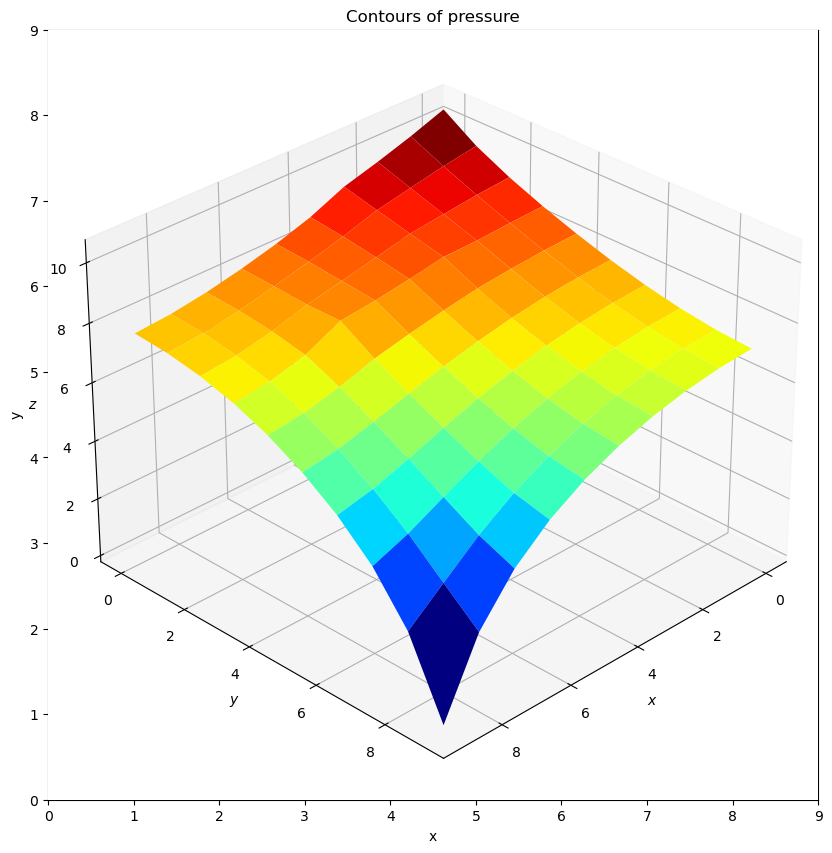

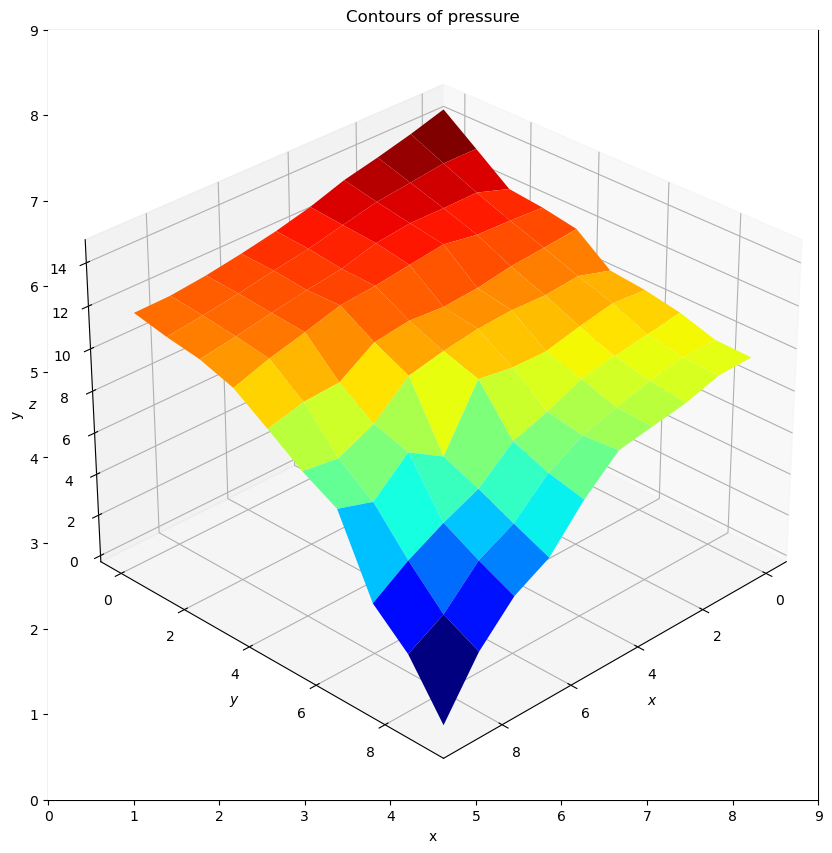

In [246]:
PlotPressureAsSurface(nx,ny,P)
PlotPressureAsSurface(nx,ny,NP)

In [229]:
Testes=10000
Nrep=[]

for i in range(Testes):
    Nrep.append(i+1)

Probab0 = MonteCarlo(0.01,Testes)
Probab1 = MonteCarlo(0.02,Testes)
Probab2 = MonteCarlo(0.03,Testes)
Probab3 = MonteCarlo(0.05,Testes)
Probab4 = MonteCarlo(0.10,Testes)
Probab5 = MonteCarlo(0.15,Testes)
Probab6 = MonteCarlo(0.17,Testes)
Probab7 = MonteCarlo(0.20,Testes)
Probab8 = MonteCarlo(0.25,Testes)
Po=[0.01,0.02,0.03,0.05,0.10,0.15,0.17,0.20,0.25]

#1min36s matriz "normal"


Text(0.5, 0.98, 'Evolução da probabilidade (P>=12) em função do número de testes')

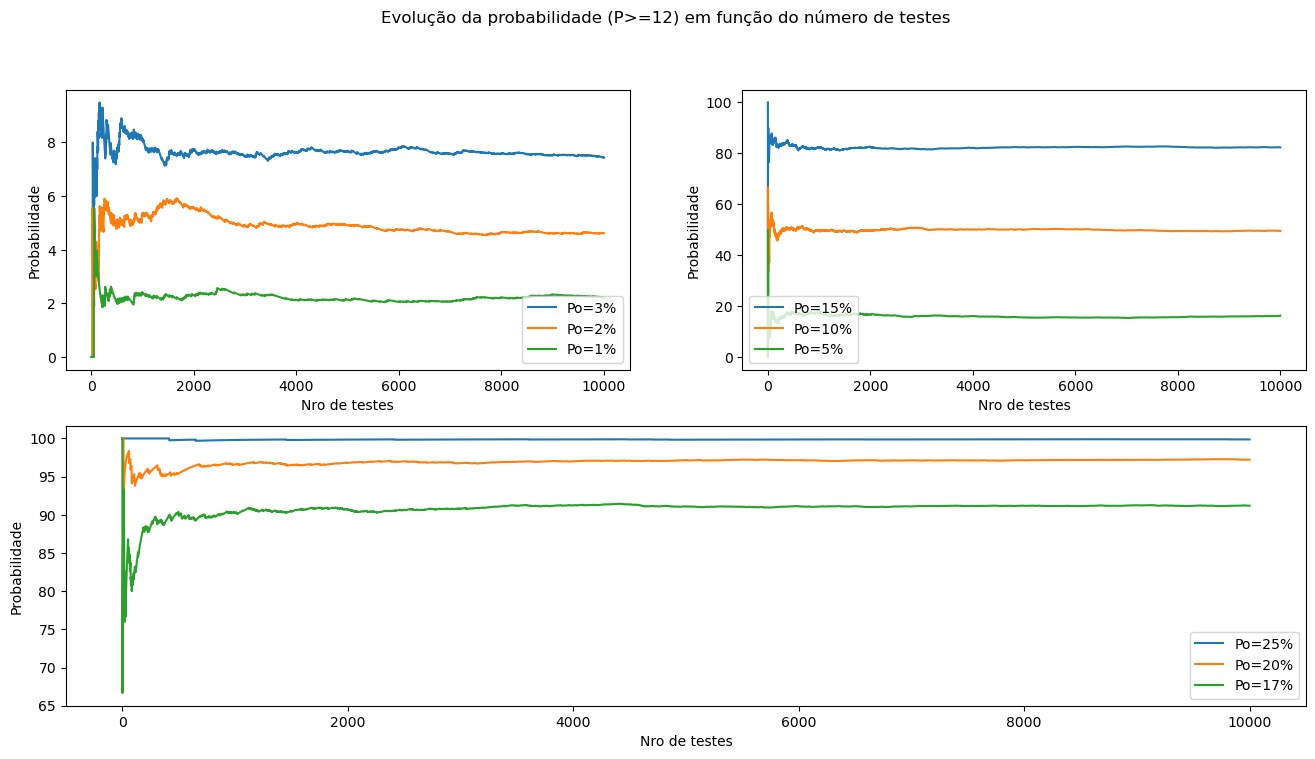

In [164]:
layout = [
    ["A", "B"],
    ["C", "C"],
]
figure, graphs = plt.subplot_mosaic(layout,figsize=(16, 8))

graphs['A'].plot(Nrep,Probab2)
graphs['A'].plot(Nrep,Probab1)
graphs['A'].plot(Nrep,Probab0)
graphs['A'].set_xlabel("Nro de testes")
graphs['A'].set_ylabel("Probabilidade")
graphs['A'].legend(['Po=3%','Po=2%','Po=1%'])

graphs['B'].plot(Nrep,Probab5)
graphs['B'].plot(Nrep,Probab4)
graphs['B'].plot(Nrep,Probab3)
graphs['B'].set_xlabel("Nro de testes")
graphs['B'].set_ylabel("Probabilidade")
graphs['B'].legend(['Po=15%','Po=10%','Po=5%'])

graphs['C'].plot(Nrep,Probab8)
graphs['C'].plot(Nrep,Probab7)
graphs['C'].plot(Nrep,Probab6)
graphs['C'].set_xlabel("Nro de testes")
graphs['C'].set_ylabel("Probabilidade")
graphs['C'].legend(['Po=25%','Po=20%','Po=17%'])

figure.suptitle('Evolução da probabilidade (P>=12) em função do número de testes')

Text(0, 0.5, 'Prob (%)')

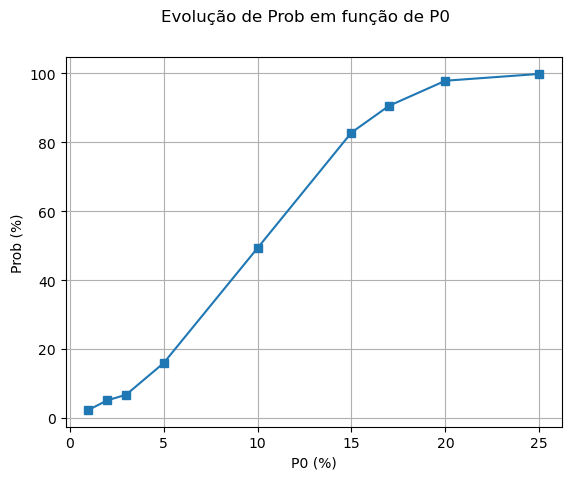

In [245]:
HighPressure=[np.average(Probab0),np.average(Probab1),np.average(Probab2),np.average(Probab3),
              np.average(Probab4),np.average(Probab5),np.average(Probab6),np.average(Probab7),np.average(Probab8)]

Percent = [i * 100 for i in Po]

fig = go.Figure(data=[go.Table(header=dict(values=['P0 (%)', 'Prob (%)']),
                 cells=dict(values=[Percent, HighPressure]))
                     ])
fig.update_layout(width=572,height=210,margin_b=1,margin_l=1,margin_r=1,margin_t=1)
fig.show()

plt.plot(Percent,HighPressure,marker='s')
plt.suptitle('Evolução de Prob em função de P0')
plt.grid()
plt.xlabel('P0 (%)')
plt.ylabel('Prob (%)')